<a href="https://colab.research.google.com/github/pihk94/DeepLearning/blob/master/Cycle_GAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning : Generative Adversarial Networksand Cycle-GAN
### May 2020 / ENSAE 
###### Melchior Prugniaud

The purpose of this notebook is to reproduce the Cycle Gan presented [here](https://junyanz.github.io/CycleGAN/) which is an Image to Image translation and transform the MNIST dataset to the USPS. 

Following the [proposed assignment](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/assignments/assignment4.pdf), we will :

* Implement Deep Convolutionnal GAN

* Implement Cycle GAN

But first of all we need to import some packages and both dataset. I will use tensorflow and keras to do it.

In [1]:
import tensorflow as tf
from tensorflow.keras.backend import resize_images
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import numpy as np
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,Conv2DTranspose,Concatenate,Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
import os
import time

Using TensorFlow backend.


# Prerequisite Datasets preprocessing

### Load MNIST Dataset
MNIST dataset consist of 70 000 digits of size 28x28.

In [0]:
train_mnist,test_mnist = mnist.load_data()
train_mnist[0].shape,train_mnist[1].shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [0]:
img_mnist,label_mnist = train_mnist[0],train_mnist[1]
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(img_mnist)):
    if not label_mnist[i] in labels and label_mnist[i] ==j:
      labels.append(label_mnist[i])
      imgs.append(img_mnist[i])
      j+=1

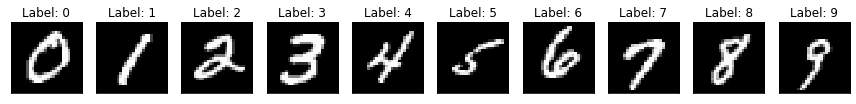

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's try to resize our image to 32 x 32 as asked in the input from the assignment.


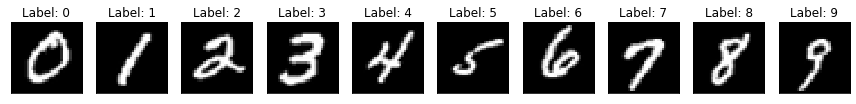

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(cv2.resize(imgs[i-1], dsize=(32,32), interpolation=cv2.INTER_CUBIC),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Looks like it's working good, we will apply it on a function to prepare datasets.
### Load USPS dataset

Let's now load the USPS dataset, unfortunately keras does not have the dataset, so we load it with torchvision.


In [0]:
from torchvision import datasets
train_usps = datasets.USPS(root='content/',download=True,train=True)
test_usps = datasets.USPS(root='content/',download=True,train=False)

In [0]:
train_usps[0]

(<PIL.Image.Image image mode=L size=16x16 at 0x7F025A020278>, 6)

In [0]:
data = train_usps
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(data)):
    if not data[i][1] in labels and data[i][1] ==j:
      labels.append(data[i][1])
      imgs.append(data[i][0])
      j+=1

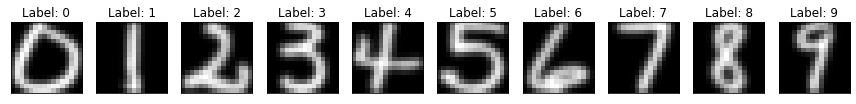

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's reshape again this 16x16 imgs to 32x32

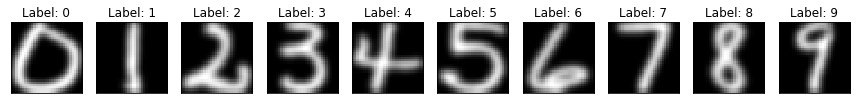

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1].resize((32,32)),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

## Prepare datasets loader

Here is two function , one for each dataset to load data in the good format for our networks.

In [0]:
def prepare_mnist_tensor(BATCH_SIZE):
  (train_img,_),(test_mnist,_) = mnist.load_data()
  train_img = train_img.reshape(train_img.shape[0],train_img.shape[1],train_img.shape[2],1)
  t = np.empty((train_img.shape[0],32,32))
  for i in range(train_img.shape[0]):
    t[i] = cv2.resize(train_img[i], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
  t = t.reshape(train_img.shape[0],32,32,1)
  train_img = t.astype('float32')
  #normalize data
  train_img = (train_img -127.5)/127.5
  return tf.data.Dataset.from_tensor_slices(train_img).shuffle(train_img.shape[0]).batch(BATCH_SIZE)

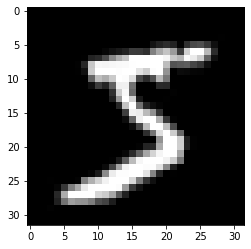

In [0]:
plt.imshow(t[0],cmap='gray',interpolation='none')

In [0]:
def prepare_mnist_cycleGAN(BATCH_SIZE,BUFFER_SIZE=1000):
  (train_img,_),(test_img,_) = mnist.load_data()
  #train_set
  train_img = train_img.reshape(train_img.shape[0],train_img.shape[1],train_img.shape[2],1)
  t = np.empty((train_img.shape[0],32,32))
  for i in range(train_img.shape[0]):
    t[i] = cv2.resize(train_img[i], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
  t = t.reshape(train_img.shape[0],32,32,1)
  train_img = t.astype('float32')
  train_img = (train_img -127.5)/127.5
  #test_set
  test_img = test_img.reshape(test_img.shape[0],test_img.shape[1],test_img.shape[2],1)
  t = np.empty((test_img.shape[0],32,32))
  for i in range(test_img.shape[0]):
    t[i] = cv2.resize(test_img[i], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
  t = t.reshape(test_img.shape[0],32,32,1)
  test_img = t.astype('float32')
  test_img = (test_img -127.5)/127.5
  return tf.data.Dataset.from_tensor_slices(train_img).shuffle(BUFFER_SIZE).batch(BATCH_SIZE),tf.data.Dataset.from_tensor_slices(test_img).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
train_mnist,test_mnist = prepare_mnist_cycleGAN(1,BUFFER_SIZE=1000)

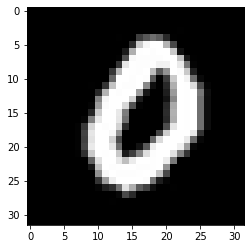

In [45]:
for batch in train_mnist:
  plt.imshow(batch[0,:,:,0],cmap='gray',interpolation='none')
  break

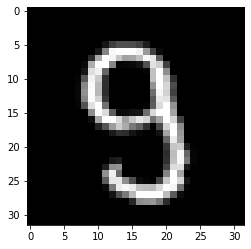

In [46]:
for batch in test_mnist:
  plt.imshow(batch[0,:,:,0],cmap='gray',interpolation='none')
  break

In [0]:
def prepare_usps_cycleGAN(BATCH_SIZE,BUFFER_SIZE=1000):
  from torchvision import datasets
  train_usps = datasets.USPS(root='content/',download=True,train=True)
  test_usps = datasets.USPS(root='content/',download=True,train=False)
  t = np.empty((len(train_usps),32,32,1))
  for i in range(len(train_usps)):
    t[i] = np.array(train_usps[i][0].resize((32,32)),dtype='float32').reshape((32,32,1))
  train_usps = t.astype('float32')
  train_usps = (train_usps-127.5)/127.5
  t = np.empty((len(test_usps),32,32,1))
  for i in range(len(test_usps)):
    t[i] = np.array(test_usps[i][0].resize((32,32)),dtype='float32').reshape((32,32,1))
  test_usps = t.astype('float32')
  test_usps = (test_usps-127.5)/127.5
  return tf.data.Dataset.from_tensor_slices(train_usps).shuffle(BUFFER_SIZE).batch(BATCH_SIZE),tf.data.Dataset.from_tensor_slices(test_usps).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
train_usps,test_usps = prepare_usps_cycleGAN(1,BUFFER_SIZE=1000)

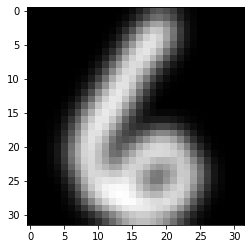

In [79]:
for batch in train_usps:
  plt.imshow(batch[0,:,:,0],cmap='gray',interpolation='none')
  break

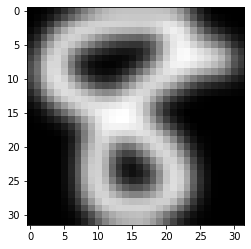

In [80]:
for batch in test_usps:
  plt.imshow(batch[0,:,:,0],cmap='gray',interpolation='none')
  break

# Part 1: Deep Convolutional GAN (DCGAN)

In the first part, the assignment ask to implement the DCGAN.
We will follow this blueprint : 

* Create discriminator

* Create generator

* Create the training procedure


## Discriminator

We have to reproduce this architecture : 


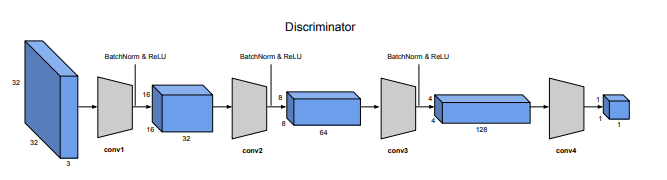

In [4]:
def dis_model(input_shape=(32,32,1)):
  init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
  padding = 'same'
  kernels = (4,4)
  strides = (2,2)
  size = 64
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(64,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(128,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model
dis_model((32,32,1)).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         2

Taking our initial shape, we got the following model for our discriminator.

## Generator

Let's now try to make the generator model. The representation is : 

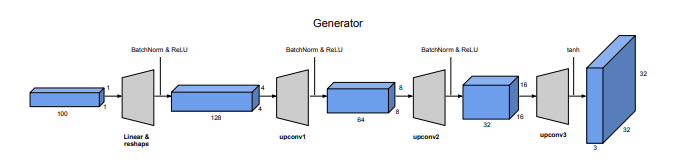

Since we have only 28x28 images, we delete one layer

In [0]:
def gen_model():
    init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*64, use_bias=False, input_shape=(100,),kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 64)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init,activation='tanh'))
    model.summary()
    return model
gen_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102400    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         204800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 4, 128)        

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_12 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 4, 4, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4, 4, 128)        

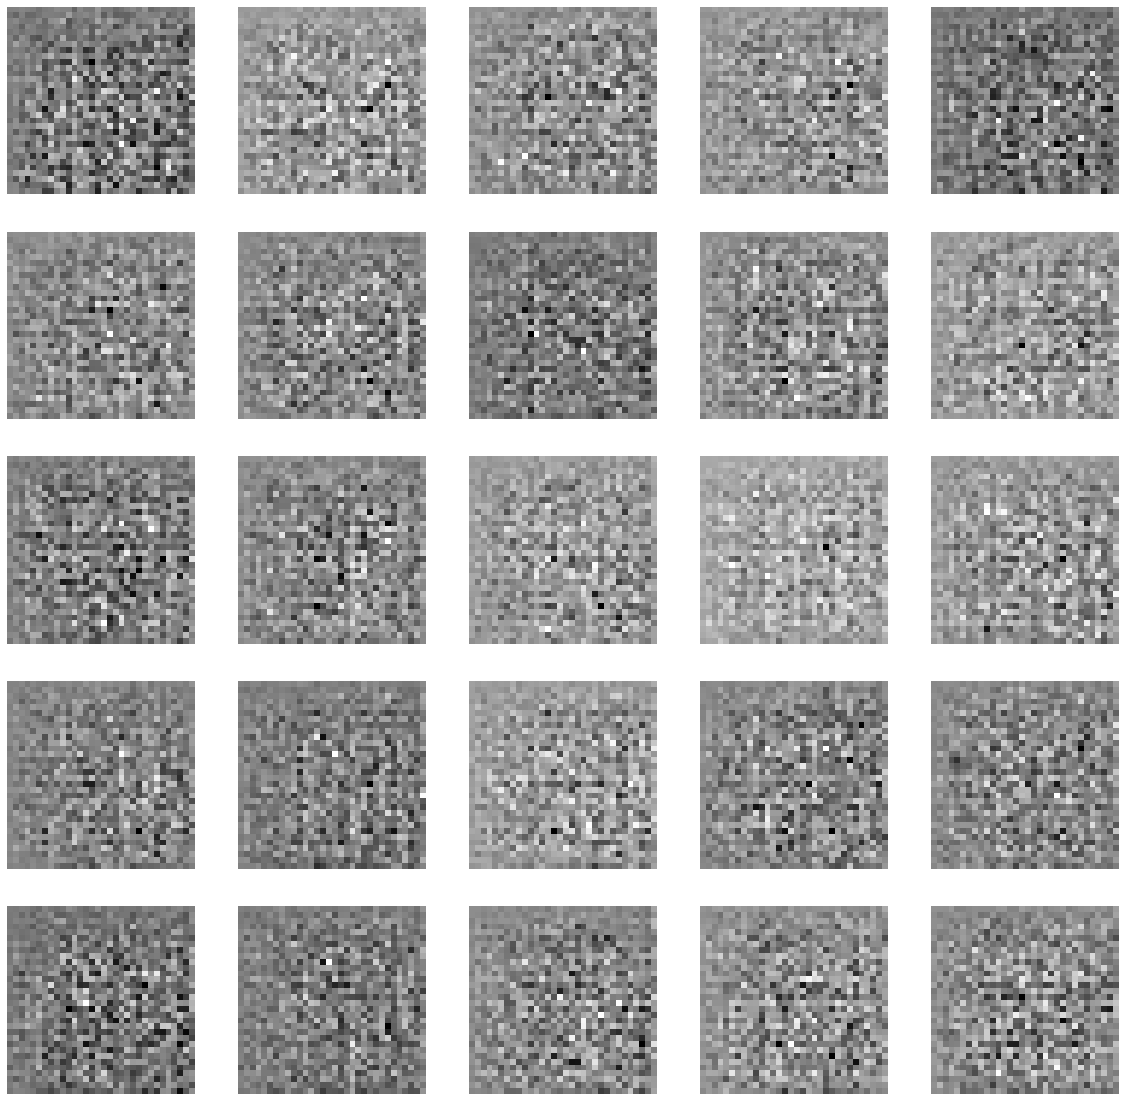

In [0]:
gen = gen_model()
noise = tf.random.normal([25, 100])
gen.training=False
X = gen(noise)
plt.figure(figsize=(20,20))
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X[i, :, :, 0], cmap='gray_r')

We then use the loss of our model

Set the seed

Save results 

Define the training step

## Training Loop


Here is a representation of the untrained generator.

In [0]:
dataset = prepare_mnist_tensor(256)

In [0]:
discriminator = dis_model()
generator = gen_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              102400    
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 128)         204800    
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4, 4, 128)        

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 25
BATCH_SIZE = 256
seed = tf.random.normal([num_examples_to_generate, noise_dim])
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss
def train(dataset, epochs):
  from IPython import display
  global_loss_gen = []
  global_loss_disc = []
  for epoch in range(epochs):
    start = time.time()
    loss_gen = []
    loss_disc = []
    for image_batch in dataset:
      (g,d) = train_step(image_batch)
      loss_gen.append(g),loss_disc.append(d)
    global_loss_gen.append(np.mean(loss_gen)),global_loss_disc.append(np.mean(loss_disc))
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    print(f'Generator loss : {np.mean(loss_gen)}\nDiscriminator loss : {np.mean(loss_disc)}')
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    plt.figure(figsize=(12,12))
    plt.plot(range(len(global_loss_gen)),global_loss_gen,color='blue')
    plt.plot(range(len(global_loss_disc)),global_loss_disc,color='red')
    plt.show()
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  plt.figure(figsize=(12,12))
  plt.plot(range(len(global_loss_gen)),global_loss_gen,color='blue')
  plt.plot(range(len(global_loss_disc)),global_loss_disc,color='red')
  plt.savefig('final.png')
  plt.show()
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(16,16))
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.suptitle(f"Epoch : {epoch}", fontsize=14)
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

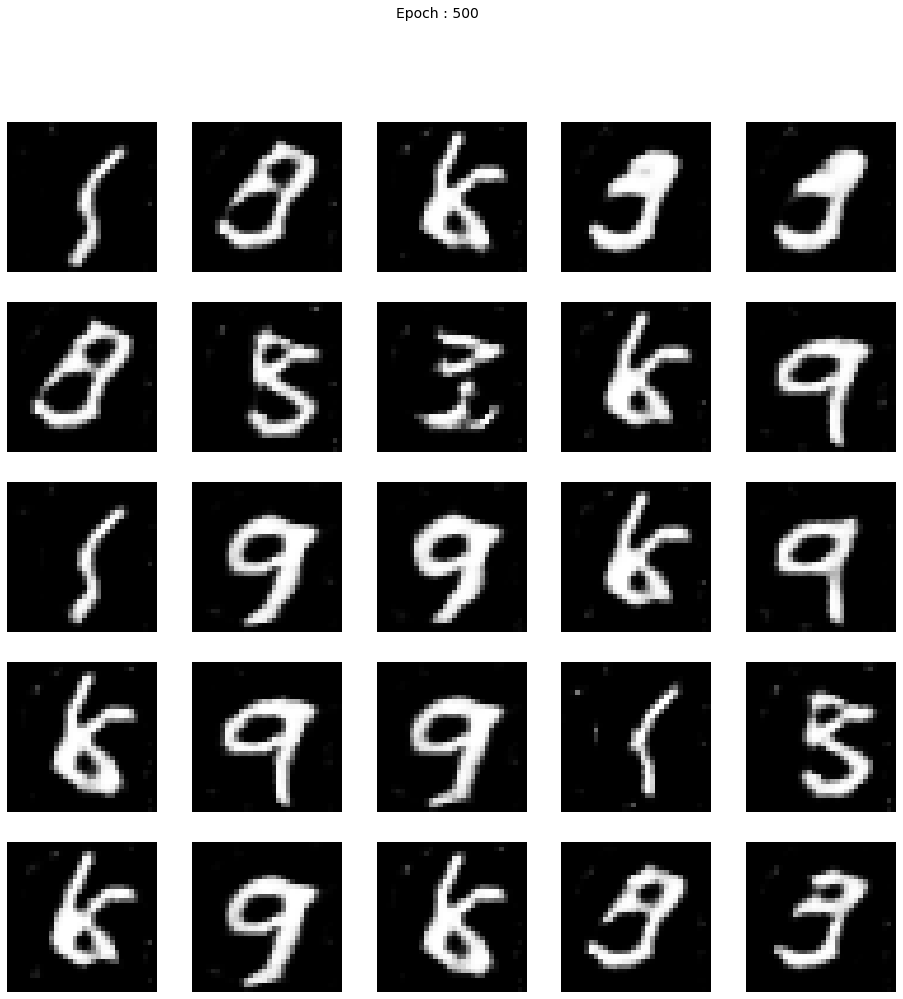

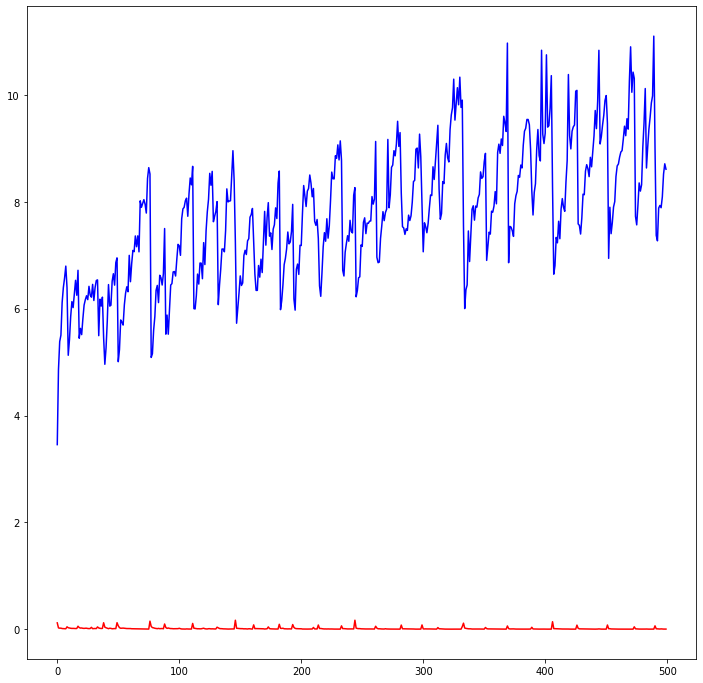

In [0]:
train(dataset, EPOCHS)

In [0]:
import imageio
import glob
anim_file = 'anim.gif'

with imageio.get_writer(anim_file, mode='I',duration='1') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

# Part 2 : Cycle GAN

### Cycle Gan Generator

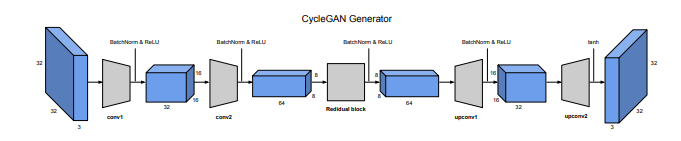

In [5]:
def generator_cycle_gan(input_shape=(32,32,1)):
  init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
  #Encoder
  Input_img = Input(shape=(32,32,1))
  conv1 = Conv2D(32,(5,5),strides=(2,2),padding='same',kernel_initializer = init)(Input_img)
  conv1 = BatchNormalization()(conv1)
  conv1 = Activation('relu')(conv1)
  conv2 = Conv2D(64,(5,5),strides=(2,2),padding='same',kernel_initializer = init)(conv1)
  conv2 = BatchNormalization()(conv2)
  conv2 = Activation('relu')(conv2) 
  #Resnet 
  resnet1 = Conv2D(64,(5,5),strides = (1,1),padding='same',kernel_initializer=init)(conv2)
  resnet1 = BatchNormalization()(resnet1)
  resnet1 = Activation('relu')(resnet1)
  resnet2 = Conv2D(64,(5,5),strides = (1,1),padding='same',kernel_initializer=init)(resnet1)
  resnet2 = BatchNormalization()(resnet2)
  resnet2 = Activation('relu')(resnet2)
  resnet_out = Concatenate()([resnet2,conv2])
  # model.add(layers.Conv2D(32,(5,5),strides =(2,2),padding = 'same',kernel_initializer=init,input_shape=input_shape))
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())
  # model.add(layers.Conv2D(64,(5,5),strides =(2,2),padding = 'same',kernel_initializer=init,input_shape=input_shape))
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())
  #Decoder
  # model.add(layers.Conv2DTranspose(32,(3,3),strides=(2,2),padding='same',kernel_initializer=init))
  # model.add(layers.BatchNormalization())
  # model.add(layers.LeakyReLU())
  # model.add(layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding='same',kernel_initializer=init))
  # model.add(layers.Activation('tanh'))
  #Decoder
  deconv1 = Conv2DTranspose(32,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(resnet_out)
  deconv1 = BatchNormalization()(deconv1)
  deconv1 = Activation('relu')(deconv1)
  out = Conv2DTranspose(1,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(deconv1)
  out = Activation('tanh')(out)
  model = Model(Input_img,out)
  model.summary()
  return model
generator_cycle_gan()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 16, 16, 32)   128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 32)   0           batch_normalization_3[0][0]      
______________________________________________________________________________________________

### Cycle Gan Discrimnator

We need to redefine a new discriminator in order to have this time an output of the image size !

In [0]:
train_mnist,test_mnist = prepare_mnist_cycleGAN(1)
train_usps,test_usps = prepare_usps_cycleGAN(1)

In [0]:
sample_mnist = next(iter(train_mnist))
sample_usps = next(iter(train_usps))

In [0]:
train_mnist_sample = []
i=0
for batch in train_mnist:
  i+=1
  train_mnist_sample.append(batch)
  train_mnist_sample.append(np.zeros((1,32,32,1)))
  if i >= 7:
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


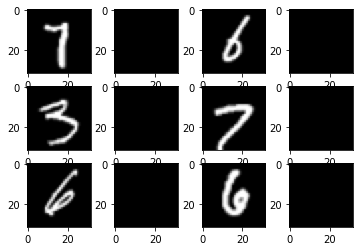

In [53]:
for i in range(11):
  plt.subplot(3,4,i+1)
  plt.imshow(train_mnist_sample[i][0,:,:,0],cmap='gray')
  plt.subplot(3,4,i+2)
  plt.imshow(train_mnist_sample[i+1][0,:,:,0],cmap='gray')

In [13]:
generator_g = generator_cycle_gan((32,32,1))
generator_f = generator_cycle_gan((32,32,1))
discriminator_x = dis_model((32,32,1))
discriminator_y = dis_model((32,32,1))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 16, 16, 32)   128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 16, 16, 32)   0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [0]:
to_usps = generator_g(sample_mnist)
to_mnist = generator_f(sample_usps)

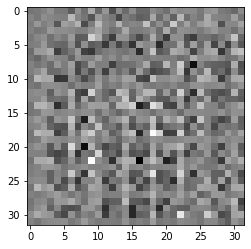

In [26]:
plt.imshow(to_mnist[0,:,:,0],cmap='gray_r')

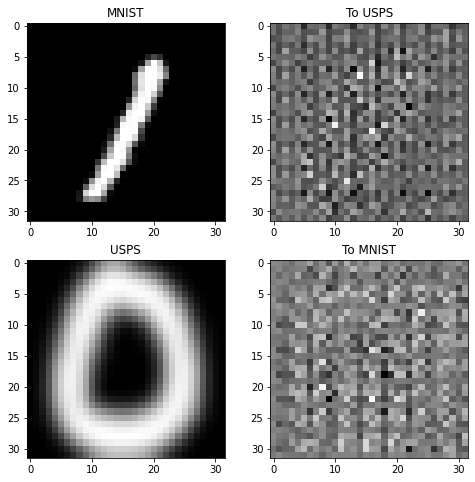

In [31]:
plt.figure(figsize=(8, 8))
contrast = 8
imgs = [sample_mnist, to_usps, sample_usps, to_mnist]
title = ['MNIST', 'To USPS', 'USPS', 'To MNIST']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0,:,:,0]* 127.5 + 127.5,cmap='gray')
  else:
    plt.imshow(imgs[i][0,:,:,0]* 127.5 + 127.5,cmap='gray')
plt.show()

In [0]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real, fake):
  real_loss = crossEntropy(tf.ones_like(real),real)
  fake_loss = crossEntropy(tf.ones_like(fake),fake)
  total = real_loss+fake_loss
  return total *0.5
def generator_loss(fake):
  return crossEntropy(tf.ones_like(fake),fake)
def cycle_gan_loss(real,cycled):
  loss = tf.reduce_mean(tf.abs(real-cycled))
  return loss * 10
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return 10 * 0.5 * loss

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
EPOCHS = 40

In [0]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i][:,:,0],cmap='gray')
    plt.axis('off')
  plt.show()

In [0]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    generator_g.trainable=True
    generator_f.trainable=True
    discriminator_x.trainable=True
    discriminator_y.trainable=True
    fake_y = generator_g(real_x)
    cycled_x = generator_f(fake_y)
    fake_x = generator_f(real_y)
    cycled_y = generator_g(fake_x)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x)
    same_y = generator_g(real_y)

    disc_real_x = discriminator_x(real_x)
    disc_real_y = discriminator_y(real_y)

    disc_fake_x = discriminator_x(fake_x)
    disc_fake_y = discriminator_y(fake_y)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = cycle_gan_loss(real_x, cycled_x) + cycle_gan_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

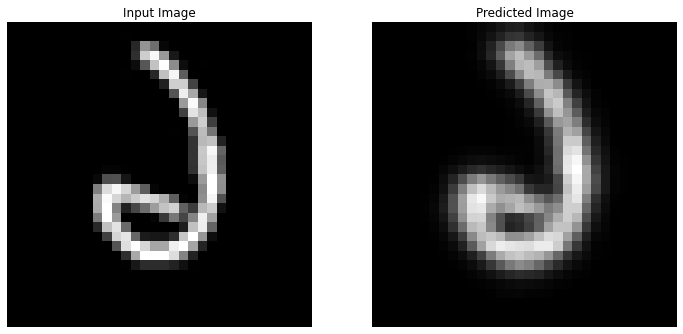

In [51]:

prediction = generator_g(sample_mnist)
  
plt.figure(figsize=(12, 12))

display_list = [sample_mnist[0], prediction[0]]
title = ['Input Image', 'Predicted Image']

for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])
  # getting the pixel values between [0, 1] to plot it.
  plt.imshow(display_list[i][:,:,0],cmap='gray')
  plt.axis('off')
plt.show()

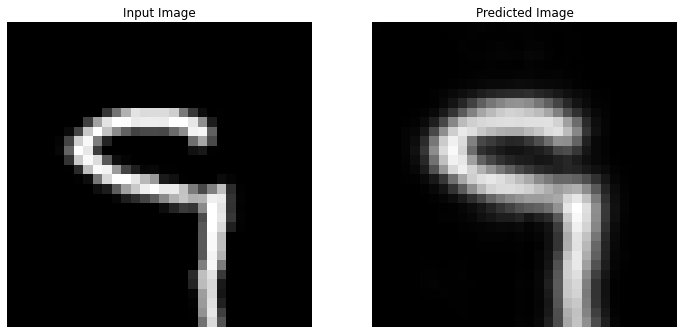

Time taken for epoch 2 is 219.11519265174866 sec

..............................................................

KeyboardInterrupt: ignored

In [17]:
from IPython import display
for epoch in range(EPOCHS):
  start = time.time()
  n = 0
  j=0
  for image_x, image_y in zip(train_mnist, train_usps):
    j+=1
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  display.clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_mnist)

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [22]:
for real_x, real_y in zip(train_mnist, train_usps):
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    generator_g.trainable=True
    generator_f.trainable=True
    discriminator_x.trainable=True
    discriminator_y.trainable=True
    fake_y = generator_g(real_x)
    cycled_x = generator_f(fake_y)
    fake_x = generator_f(real_y)
    cycled_y = generator_g(fake_x)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x)
    same_y = generator_g(real_y)

    disc_real_x = discriminator_x(real_x)
    disc_real_y = discriminator_y(real_y)

    disc_fake_x = discriminator_x(fake_x)
    disc_fake_y = discriminator_y(fake_y)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = cycle_gan_loss(real_x, cycled_x) + cycle_gan_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  break
print('ez')

ez
